In [292]:
import pandas as pd
import numpy as np
from pymoo.algorithms.nsga3 import NSGA3
from pymoo.algorithms.rnsga2 import RNSGA2
from pymoo.algorithms.rnsga3 import RNSGA3
from pymoo.algorithms.unsga3 import UNSGA3
from pymoo.factory import get_reference_directions
from pymoo.optimize import minimize
import pickle

from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination

from notebooks.optimization_problems.constraints import Requirements
from optimization_problems.biased_initialization import max_contact_biased
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [293]:
prefix = 'eo_' + 'o3b_'

case, target = pickle.load(open('raw/%ssettings.pkl' % prefix, 'rb'))

import util
util.print_targets(case)

Targets per orbit
T_target: 960.00 Gb (min: 624.00 Gb, max: 1296.00 Gb)
L_target: 0.00 s
E_target: 41.16 kJ (max: -0.00 kJ)
P_target: 0.00 s


In [294]:
columns = ['strand_name', 'tof',
           'r_a_x', 'r_a_y', 'r_a_z',
           'v_a_x', 'v_a_y', 'v_a_z',
           'r_b_x', 'r_b_y', 'r_b_z',
           'd',
           'r_ab_sff_x', 'r_ab_sff_y', 'r_ab_sff_z']

file_path = "raw/%spost_processed.h5" % prefix

row_limit = -1

store = pd.HDFStore(file_path)

instances_df = store.select('contact_instances', 'columns = %s' % str(columns), stop = row_limit)

# Sort by pass id
instances_df = instances_df.sort_index(0)

In [295]:
from notebooks.optimization_problems.design_vector import design_vector_default_scm, SystemParameters, \
    design_vector_nopasspower_scm, PassPowerSampling, PassPowerCrossover, PassPowerMutation

sys_param = SystemParameters()
sys_param.fc_Hz = target['frequency']
sys_param.GT_dBK = target['GT_dBK']
sys_param.margin_dB = 3.0
sys_param.B_Hz_array = np.array([0.1, 0.5, 1, 10, 50, 100, 200, 300]) * 1e6
sys_param.Gtx_dBi_bounds = (3., 50.)
sys_param.Ptx_dBm_bounds = (20., 43.)

modcods_df = pd.read_pickle('../dvbs2.pkl')

sys_param.EsN0_req_dB_array = modcods_df[['isend', 'isend_200MHz', 'isend_300MHz']].to_numpy()
sys_param.eta_bitsym_array = modcods_df[['eta', 'eta_200MHz', 'eta_300MHz']].to_numpy()
sys_param.eta_maee_array = modcods_df[['maee_12', 'maee_12_200MHz', 'maee_12_300MHz']].to_numpy()

requirements = case['requirements']
#requirements.max_throughput = -1

### Problem definition
Defines a ExtendandCombinedProblem

In [296]:
from combined_problem import ExtendedCombinedProblem
problem = ExtendedCombinedProblem(instances_df, sys_param, requirements=requirements, f_mask=np.array([1, 2, 3]))
sampling, crossover, mutation = design_vector_default_scm(problem.x_length, problem.x_indices)

Algorithm settings

Loaded biased initial population
Generating biased initial population
init_ref_dirs: 400
init_pop_size: 400
init_n_offsprings: 200
Running initial conditions optimization...
Plotting 10 results
Generating initial maximized population of size 300...
Loaded biased initial population
Selected setting: NSGA 3 custom xover (ref_dirs=300, pop_size=300, n_offsprings=75)


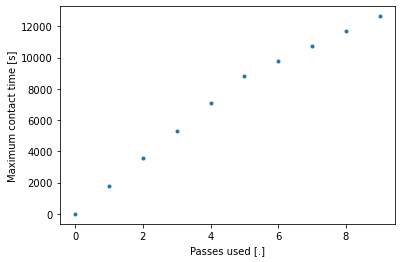

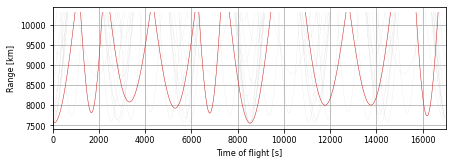

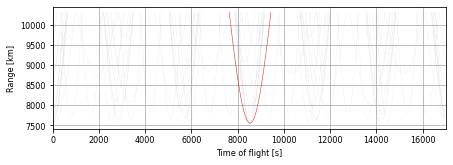

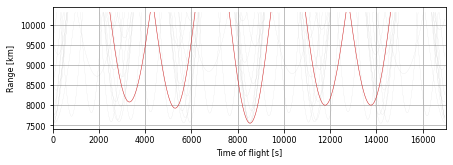

In [297]:
settings = {}

# NSGA-III
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=13)
pop_size=int(np.ceil(len(ref_dirs) / 100) * 100)
n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4)

from os import path
file_name = 'raw/%sbiased_inits.pkl' % (prefix)

if path.exists(file_name):
    print("Loaded biased initial population")
    biased_init = pickle.load(open(file_name, 'rb'))
else:
    print("Generating biased initial population")
    biased_init = max_contact_biased(instances_df, sys_param, case, pop_size, init='max')
    pickle.dump(biased_init, open(file_name, 'wb'))

settings['NSGA-III-BIASED'] = {
    'label': 'nsga3',
    'algorithm': NSGA3(
        pop_size=pop_size,
        n_offsprings=n_offsprings,
        sampling=biased_init,
        crossover=crossover,
        mutation=mutation,
        ref_dirs=ref_dirs,
        eliminate_duplicates=True,
    ),
    'desc': 'NSGA 3 biased (ref_dirs=%d, pop_size=%d, n_offsprings=%d)' % (len(ref_dirs), pop_size, n_offsprings),
    'file_label': 'nsga3_biased_%d_%d_%d' % (len(ref_dirs), pop_size, n_offsprings),
    'termination': ""
}

setting = settings['NSGA-III-BIASED']

# NSGA-III No pass cross-over
def _nsga3_nopass_xcross():    # This function references outer scope

    # Redefine problem with lower bounds
    sys_param.Ptx_dBm_bounds = (30., 46.)
    problem = ExtendedCombinedProblem(instances_df, sys_param, requirements=requirements, f_mask=np.array([1, 2, 3]))

    # Change cross-over
    sampling, crossover, mutation = design_vector_nopasspower_scm(problem.x_length, problem.x_indices)

    ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=23)
    pop_size=int(np.ceil(len(ref_dirs) / 100) * 100)
    n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4)

    file_label = 'nsga3_xover_%d_%d_%d' % (len(ref_dirs), pop_size, n_offsprings)
    init_file_name = 'raw/%s%sbiased_inits_max.pkl' % (prefix, file_label + '_')

    if path.exists(init_file_name):
        print("Loaded biased initial population")
        biased_init = pickle.load(open(init_file_name, 'rb'))
    else:
        print("Generating biased initial population")
        biased_init = max_contact_biased(instances_df, sys_param, case, pop_size, init='max', verbose=False)
        pickle.dump(biased_init, open(init_file_name, 'wb'))

    setting_dict = {
        'algorithm': NSGA3(
            pop_size=pop_size,
            n_offsprings=n_offsprings,
            sampling=biased_init,
            crossover=crossover,
            mutation=mutation,
            ref_dirs=ref_dirs,
            eliminate_duplicates=True,
        ),
        'desc': 'NSGA 3 custom xover (ref_dirs=%d, pop_size=%d, n_offsprings=%d)' % (len(ref_dirs), pop_size, n_offsprings),
        'file_label': file_label,
        'termination': ""
    }

    return problem, setting_dict

problem, setting = _nsga3_nopass_xcross()

# NSGA-III Custom cross-over
def _nsga3_xcross():    # This function references outer scope

    # Redefine problem with lower bounds
    sys_param.Ptx_dBm_bounds = (30., 43.)
    problem = ExtendedCombinedProblem(instances_df, sys_param, requirements=requirements, f_mask=np.array([0, 2, 3]))

    # Change cross-over
    def _scm(var_count, indices):
        from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableCrossover, \
            MixedVariableMutation
        from pymoo.factory import get_sampling, get_crossover, get_mutation

        mapping_mask = dict()
        mapping_mask['pass'] = "passpower"
        mapping_mask['power'] = "passpower"
        mapping_mask['antenna'] = "real"
        mapping_mask['bandwidth'] = "int"
        # mapping_mask['rolloff'] = "int"
        # mapping_mask['modcod'] = "int"

        mask = [None] * var_count
        for k, v in indices.items():
            for i in v:
                mask[i] = mapping_mask[k]

        sampling = MixedVariableSampling(mask, {
            "passpower": PassPowerSampling(get_sampling("bin_random"),get_sampling("real_random")),
            "int": get_sampling("int_random"),
            "real": get_sampling("real_random")
        })

        crossover = MixedVariableCrossover(mask, {
            "passpower": PassPowerCrossover(),
            "int": get_crossover("int_sbx", prob=1.0, eta=3.0),
            "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
        })

        mutation = MixedVariableMutation(mask, {
            "passpower": PassPowerMutation(get_mutation("bin_bitflip", prob=0.001), get_mutation("real_pm", prob=0.1, eta=3.0)),
            "int": get_mutation("int_pm", eta=3.0),
            "real": get_mutation("real_pm", eta=3.0),
        })

        return sampling, crossover, mutation

    sampling, crossover, mutation = _scm(problem.x_length, problem.x_indices)

    ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=23)
    pop_size=int(np.ceil(len(ref_dirs) / 100) * 100)
    n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 * 1/4)

    file_label = 'nsga3_xover_%d_%d_%d' % (len(ref_dirs), pop_size, n_offsprings)
    init_file_name = 'raw/%s%sbiased_inits_max.pkl' % (prefix, file_label + '_')

    if path.exists(init_file_name):
        print("Loaded biased initial population")
        biased_init = pickle.load(open(init_file_name, 'rb'))
    else:
        print("Generating biased initial population")
        biased_init = max_contact_biased(instances_df, sys_param, case, pop_size, init='max', verbose=False)
        pickle.dump(biased_init, open(init_file_name, 'wb'))

    setting_dict = {
        'algorithm': NSGA3(
            pop_size=pop_size,
            n_offsprings=n_offsprings,
            sampling=biased_init,
            crossover=crossover,
            mutation=mutation,
            ref_dirs=ref_dirs,
            eliminate_duplicates=True,
        ),
        'desc': 'NSGA 3 custom xover (ref_dirs=%d, pop_size=%d, n_offsprings=%d)' % (len(ref_dirs), pop_size, n_offsprings),
        'file_label': file_label,
        'termination': ""
    }

    return problem, setting_dict

problem, setting = _nsga3_xcross()

# R-NSGA-III custom cross-over
def _rnsga2_xcross():

    # Redefine problem with lower bounds
    sys_param.Ptx_dBm_bounds = (30., 43.)
    problem = ExtendedCombinedProblem(instances_df, sys_param, requirements=requirements, f_mask=np.array([1, 2, 3]))

    # Change cross-over
    def _scm(var_count, indices):
        from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableCrossover, \
            MixedVariableMutation
        from pymoo.factory import get_sampling, get_crossover, get_mutation

        mapping_mask = dict()
        mapping_mask['pass'] = "passpower"
        mapping_mask['power'] = "passpower"
        mapping_mask['antenna'] = "real"
        mapping_mask['bandwidth'] = "int"
        # mapping_mask['rolloff'] = "int"
        # mapping_mask['modcod'] = "int"

        mask = [None] * var_count
        for k, v in indices.items():
            for i in v:
                mask[i] = mapping_mask[k]

        sampling = MixedVariableSampling(mask, {
            "passpower": PassPowerSampling(get_sampling("bin_random"),get_sampling("real_random")),
            "int": get_sampling("int_random"),
            "real": get_sampling("real_random")
        })

        crossover = MixedVariableCrossover(mask, {
            "passpower": PassPowerCrossover(),
            "int": get_crossover("int_sbx", prob=1.0, eta=3.0),
            "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
        })

        mutation = MixedVariableMutation(mask, {
            "passpower": PassPowerMutation(get_mutation("bin_bitflip", prob=0.001), get_mutation("real_pm", prob=0.1, eta=3.0)),
            "int": get_mutation("int_pm", eta=3.0),
            "real": get_mutation("real_pm", eta=3.0),
        })

        return sampling, crossover, mutation

    sampling, crossover, mutation = _scm(problem.x_length, problem.x_indices)

    N_orbits = case['T_sim_s'] / case['T_orbit_s']
    ref_points = np.array([[case['T_bitorbit_target'] * -1 * N_orbits, case['E_Jorbit_target'] * N_orbits, 0.0]])

    pop_size=300
    n_offsprings=100

    file_label = 'rsga3_xover_%d_%d_%d' % (len(ref_dirs), pop_size, n_offsprings)
    init_file_name = 'raw/%s%sbiased_inits_max.pkl' % (prefix, file_label + '_')

    if path.exists(init_file_name):
        print("Loaded biased initial population")
        biased_init = pickle.load(open(init_file_name, 'rb'))
    else:
        print("Generating biased initial population")
        biased_init = max_contact_biased(instances_df, sys_param, case, pop_size, init='max', verbose=False)
        pickle.dump(biased_init, open(init_file_name, 'wb'))

    setting_dict = {
        'algorithm': RNSGA2(
            pop_size=pop_size,
            n_offsprings=n_offsprings,
            sampling=biased_init,
            crossover=crossover,
            mutation=mutation,
            ref_points=ref_points,
            weights=[1,1,0],
            epsilon=0.01,
            normalization='front',
            eliminate_duplicates=True,
        ),
        'desc': 'R-NSGA-2 custom xover (ref_dirs=%d, pop_size=%d, n_offsprings=%d)' % (len(ref_dirs), pop_size, n_offsprings),
        'file_label': file_label,
        'termination': ""
    }

    return problem, setting_dict

#problem, setting = _rnsga2_xcross()

# NSGA-III Custom cross-over no pointing objective
def _nsga3_xcross_2obj():

    # Redefine problem with lower bounds
    sys_param.Ptx_dBm_bounds = (30., 43.)
    problem = ExtendedCombinedProblem(instances_df, sys_param, requirements=requirements, f_mask=np.array([1, 2]))

    # Change cross-over
    def _scm(var_count, indices):
        from pymoo.operators.mixed_variable_operator import MixedVariableSampling, MixedVariableCrossover, \
            MixedVariableMutation
        from pymoo.factory import get_sampling, get_crossover, get_mutation

        mapping_mask = dict()
        mapping_mask['pass'] = "passpower"
        mapping_mask['power'] = "passpower"
        mapping_mask['antenna'] = "real"
        mapping_mask['bandwidth'] = "int"
        # mapping_mask['rolloff'] = "int"
        # mapping_mask['modcod'] = "int"

        mask = [None] * var_count
        for k, v in indices.items():
            for i in v:
                mask[i] = mapping_mask[k]

        sampling = MixedVariableSampling(mask, {
            "passpower": PassPowerSampling(get_sampling("bin_random"),get_sampling("real_random")),
            "int": get_sampling("int_random"),
            "real": get_sampling("real_random")
        })

        crossover = MixedVariableCrossover(mask, {
            "passpower": PassPowerCrossover(),
            "int": get_crossover("int_sbx", prob=1.0, eta=3.0),
            "real": get_crossover("real_sbx", prob=1.0, eta=3.0),
        })

        mutation = MixedVariableMutation(mask, {
            "passpower": PassPowerMutation(get_mutation("bin_bitflip", prob=0.001), get_mutation("real_pm", prob=0.1, eta=3.0)),
            "int": get_mutation("int_pm", eta=3.0),
            "real": get_mutation("real_pm", eta=3.0),
        })

        return sampling, crossover, mutation

    sampling, crossover, mutation = _scm(problem.x_length, problem.x_indices)

    ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=299)
    pop_size=300
    n_offsprings=100

    file_label = 'nsga3_xover_2obj_%d_%d_%d' % (len(ref_dirs), pop_size, n_offsprings)
    init_file_name = 'raw/%s%sbiased_inits_max.pkl' % (prefix, file_label + '_')

    if path.exists(init_file_name):
        print("Loaded biased initial population")
        biased_init = pickle.load(open(init_file_name, 'rb'))
    else:
        print("Generating biased initial population")
        biased_init = max_contact_biased(instances_df, sys_param, case, pop_size, init='max', verbose=False)
        pickle.dump(biased_init, open(init_file_name, 'wb'))

    setting_dict = {
        'algorithm': NSGA3(
            pop_size=pop_size,
            n_offsprings=n_offsprings,
            sampling=biased_init,
            crossover=crossover,
            mutation=mutation,
            ref_dirs=ref_dirs,
            eliminate_duplicates=True,
        ),
        'desc': 'NSGA 3 custom xover (ref_dirs=%d, pop_size=%d, n_offsprings=%d)' % (len(ref_dirs), pop_size, n_offsprings),
        'file_label': file_label,
        'termination': ""
    }

    return problem, setting_dict

#problem, setting = _nsga3_xcross_2obj()

print("Selected setting: %s" % setting['desc'])

Setting up optimization files

In [298]:
termination = setting['termination']
algorithm = setting['algorithm']

n_gen_inc = 1000

from os import path

file_name = 'raw/%s%s.pkl' % (prefix, setting['file_label'])

if path.exists(file_name):
    print("Loading starting point: %s" % file_name)
    problem, setting, res = pickle.load(open(file_name, 'rb'))
    algorithm = res.algorithm
    algorithm.has_terminated = False
    n_gen = res.algorithm.n_gen
else:
    print("Creating new starting point: %s" % file_name)
    n_gen = 0

Creating new starting point: raw/eo_o3b_nsga3_xover_300_300_75.pkl


In [299]:
n_gen = n_gen + n_gen_inc
print("Maximum number of generations: %d" % n_gen)
termination = ('n_gen', n_gen)

Maximum number of generations: 1000


In [300]:
print("Starting optimization...")

res = minimize(problem,
               algorithm,
               termination,
               #termination=termination,
               seed=1,
               #save_history=True,
               verbose=True,
               copy_algorithm=False,
               )

print('Processes:', res.exec_time)
print("Best solution found: %s" % res.X)

pickle.dump((problem, setting, res), open(file_name, 'wb'))

Starting optimization...
    1 |      10 |  0.058739160 |  0.821251334 |       1 |  0.00000E+00 |            f
    2 |      85 |  0.00000E+00 |  0.519691306 |       9 |  1.383990814 |        ideal
    3 |     160 |  0.00000E+00 |  0.521612833 |      14 |  0.044466650 |            f
    4 |     235 |  0.00000E+00 |  0.493723097 |      14 |  0.133249042 |        ideal
    5 |     310 |  0.00000E+00 |  0.461244364 |      18 |  0.062323216 |        nadir
    6 |     385 |  0.00000E+00 |  0.302578007 |      19 |  0.168868981 |        ideal
    7 |     460 |  0.00000E+00 |  0.190809222 |      22 |  0.025636233 |            f
    8 |     535 |  0.00000E+00 |  0.112905522 |      24 |  0.019916648 |            f
    9 |     610 |  0.00000E+00 |  0.064549073 |      23 |  0.009694193 |            f
   10 |     685 |  0.00000E+00 |  0.027415640 |      22 |  0.009695204 |            f
   11 |     760 |  0.00000E+00 |  0.007976548 |      25 |  0.014234160 |        ideal
   12 |     835 |  0.00000E+0

In [301]:
from beepy import beep
for i in range(3):
    beep(sound=5)
